This notebook is a collection of code and personal notes following *Chapter 4: Training Models* of *Hands-On Machine Learning with SciKit-Learn & TensorFlow* by Aurelien Geron 1st Ed. Some of the code may be different than in the book to conform to updated standards/libraries or reflect personal investigations.

One of the most simple Machine Learning models we can consider is Linear Regression. A Linear Regression model is simply a weighted sum of the input features. In training the model we are trying to learn the optimal weights for each feature. The prediction function or *hypothesis* is given by
$$ h_\theta(x_1\dots x_n) = \theta_0 + \theta_1x_1 + \theta_2x_2 + \dots + \theta_nx_n$$
Here, $n$ is the number of features, $x_j$ is the $j$th feature, $\theta_j$ is the weight of the $j$th feature, and $h_\theta(x_1\dots x_n)$ is the predicted value. The subscript $\theta$ on the predicted value conveys that the prediction depends on the weights $\theta_0\dots \theta_n$. In practice, computations are vectorized, that is they consist of matrices and vectors of varying dimensions. We can rewrite the Linear Regression model hypothesis function as
$$ h_\theta(\mathbf{x}) = \mathbf{\theta}^T\mathbf{x}$$
Where $\mathbf{\theta}$ is a column vector consisting of the weights $\theta_0\dots \theta_n$ and $\mathbf{x}$ is the feature vector containing the values $x_1\dots x_n$. Here we take the *transpose* of $\mathbf{\theta}$ so that it becomes a row vector and the matrix multiplication of the two vectors is well-defined.


In training a regression model, we usually try to minimize the Mean Squared Error. We can write this down in vectorized form for a training set $\mathbf{X}$ with $n$ data points as
$$ MSE(\mathbf{X}, h_\theta) = \frac{1}{n}\sum_{i=1}^n\left(\mathbf{\theta}^T\mathbf{x}^{(i)}-y^{(i)}\right)^2$$
What is happening is that we are taking one of the $n$ data points in our training set $\mathbf{x}^{(i)},\,i\in\{1\dots n\}$, feeding it through our hypothesis function $\mathbf{\theta}^T\mathbf{x}^{(i)}$, subtracting the value of the label $y^{(i)}$ (note that this is a scalar not a vector), and squaring it. We do this for every data point in our training set, sum up the results, and divide by the number of data points. This gives us the Mean Squared Error. Now how do we minimize it? 


In the case of Linear Regression, we have two good choices for learning the optimal parameters. There exists a closed-form solution whcih returns the optimal parameters called the *Normal Equation*. This is given by
$$ \mathbf{\hat\theta} = \left(\mathbf{X}^T\mathbf{X} \right)^{-1}\mathbf{X}^T\mathbf{y}$$
We can generate some sample linear data to test this out.

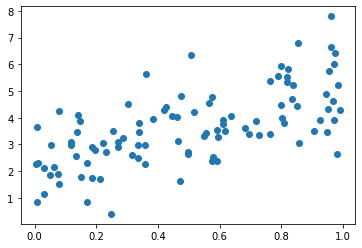

In [2]:
import numpy as np
import matplotlib.pyplot as plt
X = np.random.rand(100,1)
y = 2 + 3*X + np.random.randn(100,1)
plt.scatter(X,y)
plt.show()

We need to add a column of 1s to ```X``` so that the matrix multiplication dimensions workout (recall that there is a $\theta_0$ term with weight 1)

In [2]:
# This function takes two row vectors, makes them columns, and joins them side by side
X_1 = np.c_[np.ones((100,1)), X]
# Implementation of Normal Equation using built in NumPy linear algebra routines
theta_optimal = np.linalg.inv(X_1.T.dot(X_1)).dot(X_1.T).dot(y)
theta_optimal

array([[2.00476495],
       [2.76075133]])

Now we that we have the optimal parameters stored in ```theta_optimal``` we can make predictions. An easy way to plot a linear model, rather than evaluating it at a large series of points in an interval, is two evaluate it at the two endpoints of the interval and let ```matplotlib``` connect the two dots with a line.

[[2.00476495]
 [4.76551628]]


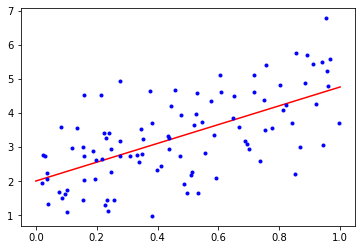

In [3]:
X_pred = np.array([[0],[1]])
X_pred_1 = np.c_[np.ones((2,1)), X_pred]
predictions = X_pred_1.dot(theta_optimal)
print(predictions)
plt.plot(X_pred, predictions, 'r-')
plt.plot(X, y, 'b.')

It is easy to train a Linear Regression model using Scikit-Learn. Using the built-in model also has the benefit of making available several convenient functions to make predictions and access values.

In [4]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.predict(X_pred)

array([[2.00476495],
       [4.76551628]])

Scikit-Learn's implementation of Linear Regression is based on ```np.linalg.lstsq()``` which leverages ```np.linalg.pinv()``` to compute a Moore-Penrose pseudoinverse via *Singular Value Decomposition* (SVD) available via ```np.linalg.svd()```. This approach is more computationally efficient than the Normal Equation. The computational complexity of various approaches is important to consider as training sets get large, number of features grows, and compute becomes expensive. The Normal Equation requires finding an inverse which has a comutational complexity of $O(n^{2.4})$ to $O(n^3)$ depending on implementation where $n$ is the number of features. The SVD approach that Scikit-Learn uses has a computational complexity of $O(n^2)$. Both scale linearly with the size of the training data.

The alternative to these closed-form approaches is to use Gradient Descent to learn the optimal parameters. The idea behind gradient descent is iteratively tweaking parameters to minimize a given cost function. This philosophy is very general and thus it is applicable to a wide variety of problems. In the case of linear regression we are trying to minimze the $MSE$ by updating the $\mathbf{\theta}$ parameters. We do this by iteratively updating the $\theta_j$ parameter as follows
$$ \theta_{j} \to \theta_j-\alpha\frac{\partial}{\partial \theta_j}MSE(\mathbf{\theta})$$
That is we are iteratively subtracting the gradient of the cost function from the parameters weighted by $\alpha$ which we call the *learning rate*. The learning rate is thus a tunable hyperparameter. This, coupled with the fact that this process drives the value of the cost function down is where gradient descent gets its name. In general, the surfaces corresponding to particular cost functions are very complicated, containing local minima and plateau regions which could cause trouble converging to an optimal solution depending on the learning rate. The simple form of the cost function for linear regression admits a convex cost function surface which converges well for sufficiently small learning rate. Now we can implement gradient descent to find the optimal $\mathbf{\theta}$. First note that the derivative of the MSE with respect to the parameter $\theta_j$ is given easily by the chain rule to be
$$ \frac{\partial}{\partial \theta_j}MSE(\mathbf{\theta}) = \frac{2}{n}\sum_{i=1}^n \left(\mathbf{\theta}^T\mathbf{x}^{(i)}-y^{(i)}\right)x_j^{(i)}$$
So that the full gradient is given by
$$ \nabla_{\mathbf{\theta}} MSE(\mathbf{\theta})= \frac{2}{n}\mathbf{X}^T(\mathbf{X}\mathbf{\theta}-\mathbf{y})$$
We can implement this with some choice of hyperparameters as below and see that it converges to the same values as the previous two approaches.

In [5]:
# Learning rate
alpha = .1
n_iterations = 1000
# Number of data points
n = 100

# Initialize random parameters with normally distributed random values in an array of shape (2,1)
theta = np.random.randn(2,1)

for iteration in range(n_iterations):
    gradients = 2/n * X_1.T.dot(X_1.dot(theta)-y)
    theta = theta - alpha*gradients
theta

array([[2.00476557],
       [2.76075009]])

Note that this implementation requires a computation to be done on the entire training set at each iteration. This algorithm is often called *Batch* Gradient Descent because it uses the entire batch of data at each iteration. For very large data sets this can become prohibitvely slow. As an alternative we can use *Stochastic* Gradient Descent, which selects one data point at random to perform the parameter update calculation with. A side effect of this implementation is that the cost function value will not decrease monotonically as before but rather jump up and down as it decreases over time. This random behavior could cause problems with convergence. To remedy this we modify the learning rate over time according to a specific *learning schedule*. Below is an implementation of Stochastic Gradient Descent with a learning schedule given by
$$ \alpha = \frac{t_0}{t+t_1}$$
Here $t_0$ and $t_1$ are hyperparameters and $t$ is a variable given by
$$ t = en+i$$
Where $e$ is the epoch. This learning schedule ensures that the learning rate decreases monotonically over time. Note that in Stochastic Gradient Descent the value of the gradients is missing the $1/n$ term as no normalization is required when we are only treating one data point. 

In [9]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t+t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(n):
        random_index = np.random.randint(n)
        xi = X_1[random_index: random_index+1]
        yi = y[random_index]
        gradients = 2 * xi.T.dot(xi.dot(theta)-yi)
        alpha = learning_schedule(epoch*n+i)
        theta = theta - alpha*gradients
theta

array([[2.04408425],
       [2.66390231]])

We can use Scikit-Learn to train a Linear Regression model with Stochastic Gradient Descent via the ```SGDRegressor``` class. It has its own default learning schedule and the initial learning rate can be set with ```eta0=```. Setting ```penalty=None``` does not include a regularization method. More on this later.

In [13]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty=None, eta0=0.1)
# .ravel() function flattens the y vector to 1D as required by the constructor of SGDRegressor
sgd_reg.fit(X,y.ravel())
print(sgd_reg.intercept_, sgd_reg.coef_)

[2.05442227] [2.67617333]


A natural extension of Stochastic Gradient Descent is Mini-batch Gradient Descent in which rather than randomly picking a single instance to update parameters with at each training step we pick a mini-batch of training instances to perform the parameter update. The behavior of Mini-batch Gradient Descent is less erratic than that of pure Stochastic Gradient Descent and it can be run on GPUs for perfomance boosts.

So far we have only considered linear models. In the case of data which appears to have a polynomial relationship, this will not suffice. We can learn polynomial models by extending our dataset features to include powers of those features. We can do this by creating an instance of the ```PolynomialFeatures``` class (built-in to Scikit-Learn) and calling the ```fit_transform()``` function on our data. With this, we can use a ```LinearRegression``` model on this new set of features to learn the parameters of the polynomial model. Note that the ```fit_transform``` function will also add all the combinations of features, not just their individual powers, to the feature set. For a degree $d$ model with $n$ features the totla number of features after the transformation is 
$$\frac{(n+d)!}{n!d!}$$
Let us test this by generating some polynomial data and fitting a linear model to it.

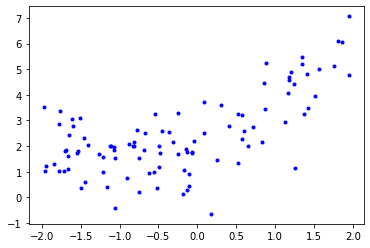

In [32]:
n = 100
X = 4*np.random.rand(n,1) - 2
y = .5*X**2 + X + 2 + np.random.randn(n,1)
plt.plot(X,y, 'b.')

In [33]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print(lin_reg.intercept_, lin_reg.coef_)

[1.91597341] [[0.98904062 0.57735654]]


Our goal in training these models is ultimately to learn a model that generalizes well, that is it performs well on new data. Previously, we used cross-validation to test generalization performance. Using cross-validation, if a model performs well on the training data but poorly according to cross-validation metrics then it is said to overfit and if it does poorly on both it is said to underfit. Another way to analyze these kind of relationships is via *learning curves*. A learning curve is a plot of a models performance on the training set and validation set as a function of either training set size or training iteration. This allows us to analyze the generalization performance and diagnose errors visually over the course of training. Below is an implementation of this idea tested on a new linear model.

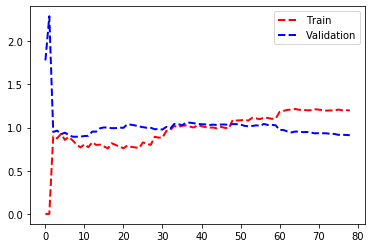

In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curve(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        training_predictions = model.predict(X_train[:m])
        validation_predictions = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], training_predictions))
        val_errors.append(mean_squared_error(y_val, validation_predictions))
    plt.plot(np.sqrt(train_errors), 'r--', linewidth=2, label="Train")
    plt.plot(np.sqrt(val_errors), 'b--', linewidth=2, label='Validation')
    plt.legend()
    plt.show()

new_lin_reg = LinearRegression()
plot_learning_curve(new_lin_reg, X, y)


Due to the fact that the data I generated earlier is actually fairly linear, the learning curve is reasonable. If the model were overfitting we would see a low training error and a high validation error thus there would be a gap between the curves. When training regression models it is important to keep in mind the Bias/Variance trade off. The generalization error of a model can be broken down into three pieces: Bias, Variance, and Noise. The Bias is the structure of the hypothesis function for a given model. If we train a linear model we are assuming that the underlying distribution of the data is linear. This is our own inductive bias and can be a source of error. For example, if we try to fit a linear model to polynomial data we will see the inductive bias take effect as the linear model can never learn the curvature associated with polynomial features and thus has some irreducible error. The Variance is the model's sensitivity to variations in the training data. For example, if we train a very high degree polynomial model on quadratic data the models parameters will vary wildly with each additional point of trianing data introduced. The Noise is the intrinisic error in the data that is irreducible without pre-processing. Decreasing Bias increases variance and vice-versa, so an ideal model choice balances the two.

Regularized Linear Models are linear models that have been trained using a regularization technique. Regularization techniques usually involve adding a term to the cost function during training to enforce some kind of behavior. Regularized models are used to reduce the variance of models effectively "smoothing" them out. The first regularized model we will consider is the Ridge Regression model which is a Linear Regression (remember this can still mean that it is polynomial as implemented earlier) with an extra term. Due to the fact that optimization routines in this setting work to minimize the cost function, this additional term penalizes large parameters which produces the smoothing. The full cost function is below
$$ J(\mathbf{\theta}) = MSE(\mathbf{\theta})+\frac{\alpha}{2}\sum_{i=1}^n \theta_i^2$$
In vectorized form, if we let $\mathbf{\theta}$ be the vector containing the parameters $\theta_1\dots \theta_n$ as usual, then the extra term is equal to
$$ \frac{\alpha}{2}(||\mathbf{\theta}||_2)^2$$
Where $||\mathbf{\theta}||_2$ is the $L2$-Norm (square root of sums of the squares). For this, Ridge Regression is sometimes referred to as $L2$-Regularization. A Ridge Regression model can be trained either via a closed-form solution or through Stochastic Gradient Descent. Below is an example of both on some artifical data meant to showcase the smoothing. Note that using ```Ridge``` allows you to specify the weighting of the penalty term via the ```alpha``` keyword argument while ```SGDRegressor``` leaves it as 1. Increasing $\alpha$ penalizes large parameter values and thus flattens the model.

We can use Scikit-Learn's ```Pipeline``` feature to compile a model by sequentially applying transformations (classes that implement ```fit_transform``` methods) and feeding them to a model at the end of the argument list.

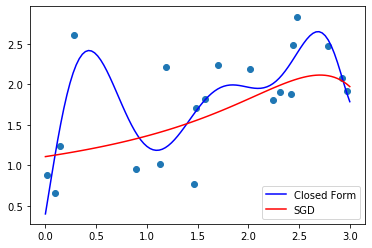

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

np.random.seed(99)
n = 20
X = 3 * np.random.rand(n, 1)
y = 1 + 0.5 * X + np.random.randn(n, 1) / 1.5
X_predict = np.linspace(0, 3, 100).reshape(100, 1)

from sklearn.linear_model import Ridge
ridge_reg = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", Ridge(alpha=1e-8, solver='cholesky')),
                ])
ridge_reg.fit(X,y.ravel())
ridge_reg_predictions = ridge_reg.predict(X_predict)

sgd_ridge_reg = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", SGDRegressor(penalty='l2')),
                ])
sgd_ridge_reg.fit(X, y.ravel())
sgd_ridge_reg_predictions = sgd_ridge_reg.predict(X_predict)

plt.scatter(X,y)
plt.plot(X_predict, ridge_reg_predictions, 'b-', label="Closed Form")
plt.plot(X_predict, sgd_ridge_reg_predictions, 'r-', label="SGD")
plt.legend()
plt.show()

An important thing to consider when working with these types of regression models is that they are sensitive to the scale of the data and thus your data should be put through a ```StandardScaler``` to be standardized. This will both improve the accuracy of the learned parameters as well as the performance of Gradient Descent optimization routines. 

An alternative to Ridge Regression is *Least Absolute Shrinkage and Selection Operation Regression*, simply referred to as Lasso Regression. It is identical in principle to Ridge Regression except the penalty is in the form of an $L1$-Norm so that the cost function is
$$ J(\mathbf{\theta}) = MSE(\mathbf{\theta})+\alpha\sum_{i=1}^n |\theta_i|$$
The difference in the two is that Lasso Regression outputs *sparse* models, that is models with few nonzero feature weights, while Ridge Regression does not. In a sense, Lasso Regression does feature selection for you in that unimportant features will have near-zero weights. The $L1$-Norm is non-differentiable at $\theta_i=0$ so at this point we assign it a subgradient vector $g$ given by
$$ g(\mathbf{\theta},J) = \nabla_{\mathbf{\theta}}MSE(\mathbf{\theta}) + \alpha \begin{pmatrix} \text{sign}(\theta_1) \\ \text{sign}(\theta_2) \\ \dots \\ \text{sign}(\theta_n) \end{pmatrix}$$
Where the sign function is defined as
$$ \text{sign}(\theta_i) = \begin{cases} -1 & \theta_i < 0 \\ 0 & \theta_i = 0 \\ 1 & \theta_i > 0  \end{cases}$$
We can implement Lasso Regression just as with Ridge Regression, either via its dedicated class or via ```SGDRegressor``` with ```penalty='l1'```

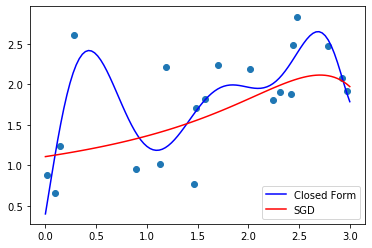

In [98]:
from sklearn.linear_model import Lasso
lasso_reg = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", Lasso(alpha=.1)),
                ])
lasso_reg.fit(X,y.ravel())
lasso_reg_predictions = ridge_reg.predict(X_predict)

sgd_lasso_reg = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", SGDRegressor(penalty='l1')),
                ])
sgd_lasso_reg.fit(X, y.ravel())
sgd_lasso_reg_predictions = sgd_ridge_reg.predict(X_predict)

plt.scatter(X,y)
plt.plot(X_predict, ridge_reg_predictions, 'b-', label="Closed Form")
plt.plot(X_predict, sgd_ridge_reg_predictions, 'r-', label="SGD")
plt.legend()
plt.show()


We can generalize these two models in a straightforward way by using Elastic Net. Elastic Net is a regression model that includes both the $L1$ and $L2$ penalty along with a mixing ratio $r$. The cost function is given by
$$ J(\mathbf{\theta}) = MSE(\mathbf{\theta}) + \alpha\left[r\sum_{i=1}^n |\theta_i| + \frac{(1-r)}{2}\sum_{i=1}^n \theta_i^2\right]$$
The mixing ratio $r$ allows us to control how much of each penalty is being used. Setting it to 1 makes it a Lasso regression and setting it to 0 makes it a Ridge Regression. It is generally a good idea to include some regularization. The choice comes down to whether or not sparsity is important. Elastic Net is preferred over Lasso Regression because Lasso may behave irregularly in low-data or strong feature correlation situations. Below is an implementation of Elastic Net with a mixing ratio of ```l1_ratio=.5```  

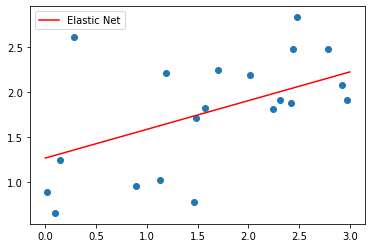

In [104]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=.1, l1_ratio=.5)
elastic_net.fit(X,y)
elastic_net_predictions = elastic_net.predict(X_predict)

plt.scatter(X,y)
plt.plot(X_predict, elastic_net_predictions, 'r-', label="Elastic Net")
plt.legend()
plt.show()


One way to reduce training times when using Gradient Descent optimization algorithms is to implement Early Stopping. Early stopping is when we stop iterating the parameters when the validation error reaches a minimum. Verifying that the validation error reaches a minimum during training can be difficult particularly for stochastic gradient descent algorithms where the valdation loss oscillates. Below is a simple implementation of early stopping.

In [ ]:
from sklearn.base import clone

# Assuming here that we have a pre-prepared X_train and X_val
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])
X_train_scaled = poly_scaler.fit_transform(X_train)
X_val_scaled = poly_scaler.fit_transform(X_val)

sgd_reg = SGDRegressor(n_iter=1, warm_start=True, penalty=None, learning_rate="constant", eta0=.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_scaled, y_train)
    predictions = sgd_reg.predict(X_val_scaled)
    val_error = mean_squared_error(y_val, predictions)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)


Regression models can also be used for classification. The prototypical example of this is *Logistic Regression*. Logistic Regression, like normal Linear Regression, takes a weighted sum of the inputs but then it feeds them through a sigmoid function which returns an estimated probability $\hat p$. The hypothesis function is
$$ \hat p = h_\mathbf{\theta}(\mathbf{x}) = \sigma(\mathbf{\theta}^T\mathbf{x}) = \frac{1}{1+\exp(\mathbf{\theta}^T\mathbf{x})}$$
The Sigmoid function squeezes the output between 0 and 1 is thus suitable for outputting probabilities. The classification prediction $\hat y$ is then determined as follows
$$ \hat y = \begin{cases} 0 & \hat p < .5 \\ 1 & \hat p \geq .5 \end{cases}$$
The loss function for Logistic Regression, often called the log loss, is given by
$$ J(\theta) = -\frac{1}{m}\sum_{i=1}^m [y_i\log(\hat p_i)+(1-y_i)\log(1-\hat p_i)]$$
Recalling that $\hat p=\sigma(x^T\theta)$ we find that the derivative of the log loss is given by 
$$ \nabla J(\theta) = \frac{1}{m}\sum_{i=1}^m (\sigma(\theta^Tx_i)-y_i)x_i$$
Lets fit a logistic regression model to the Iris data set.

In [4]:
#Loading the data
from sklearn import datasets
iris = datasets.load_iris()
#Extracting the pedal width feature
X = iris["data"][:,3:] 
#Extracting the labels
y = (iris["target"]==2).astype(np.int)

In [5]:
#Fitting the model
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression()

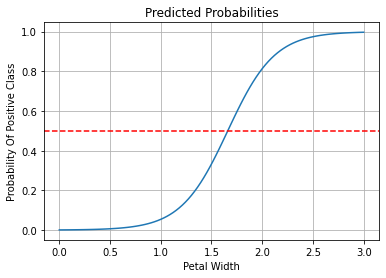

In [6]:
#Plotting predicted probabilities
X_pred = np.linspace(0,3,100).reshape(-1,1)
y_pred = log_reg.predict_proba(X_pred)
plt.plot(X_pred, y_pred[:,1])
plt.title("Predicted Probabilities")
plt.xlabel("Petal Width")
plt.ylabel("Probability Of Positive Class")
plt.axhline(y=.5,color="r", linestyle="--")
plt.grid()